# Experimento: Backpropagation en 2D

Este notebook presenta una implementación del algoritmo de Backpropagation en Python. Se utiliza un conjunto de datos sintético bidimensional para visualizar de forma intuitiva cómo una red neuronal aprende a clasificar los datos al ajustar sus fronteras de decisión.

In [15]:
# Importar las bibliotecas de cálculo numérico, generación de datos y visualización
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

## 1. Clases y Funciones del Algoritmo

Esta sección contiene las funciones de ayuda para las activaciones y la pérdida, así como la clase principal `NeuralNetwork`. El método `fit` de esta clase implementa el bucle de entrenamiento, incluyendo la propagación hacia adelante, la retropropagación del error y la actualización de los parámetros, tal como se detalla en el reporte.

In [17]:
# --- Funciones de Activación y Pérdida ---
def sigmoid(x):
    """Función de activación Sigmoide."""
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Derivada de la Sigmoide."""
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    """Función de activación ReLU."""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivada de la ReLU."""
    return (x > 0).astype(float)

def softmax(x):
    """Función de activación Softmax."""
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def categorical_cross_entropy(y_true, y_pred):
    """Función de pérdida de Entropía Cruzada Categórica."""
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    N = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred)) / N

# --- Clase NeuralNetwork ---
class NeuralNetwork:
    """Implementación de una red neuronal con el algoritmo de Backpropagation literal."""
    def __init__(self, layers_dims, activation_fn=relu):
        self.layers_dims = layers_dims
        self.num_layers = len(layers_dims)
        self.activation_fn = activation_fn
        self.activation_fn_prime = relu_derivative if activation_fn == relu else sigmoid_derivative
        self.params = {}
        for l in range(1, self.num_layers):
            # Inicialización de He para los pesos
            scale = np.sqrt(2. / self.layers_dims[l-1])
            self.params[f'W{l}'] = np.random.randn(layers_dims[l-1], layers_dims[l]) * scale
            self.params[f'b{l}'] = np.zeros((1, layers_dims[l]))
        # Lista para almacenar la pérdida promedio de cada época
        self.loss_history = []  

    def forward_pass(self, X):
        """Propagación hacia adelante para un solo ejemplo."""
        activations = {'a0': X}
        pre_activations = {}
        A_prev = X
        for l in range(1, self.num_layers):
            W = self.params[f'W{l}']
            b = self.params[f'b{l}']
            Z = np.dot(A_prev, W) + b
            pre_activations[f'z{l}'] = Z
            if l == self.num_layers - 1:
                A_prev = softmax(Z.reshape(1, -1))
            else:
                A_prev = self.activation_fn(Z)
            activations[f'a{l}'] = A_prev
        return activations, pre_activations

    def backward_pass(self, X, Y, activations, pre_activations):
        """Retropropagación para un solo ejemplo."""
        grads = {}
        # Derivada simplificada para la capa de salida (Softmax + Categorical Cross-Entropy)
        dA = activations[f'a{self.num_layers-1}'] - Y
        for l in reversed(range(1, self.num_layers)):
            A_prev = activations[f'a{l-1}']
            Z = pre_activations[f'z{l}']
            if l == self.num_layers - 1:
                dZ = dA
            else:
                # Retropropagación del error a través de las capas ocultas
                dZ = np.dot(dA, self.params[f'W{l+1}'].T) * self.activation_fn_prime(Z)
            dW = np.dot(A_prev.T, dZ)
            db = dZ
            grads[f'dW{l}'] = dW
            grads[f'db{l}'] = db
            dA = dZ
        return grads

    def fit(self, X, Y, epochs, batch_size, learning_rate):
        """Implementación literal del bucle de entrenamiento del pseudocódigo."""
        m = X.shape[0]
        self.loss_history = []  # Reiniciar el historial de pérdida para un nuevo entrenamiento
        for i in range(1, epochs + 1):
            # Mezclar los datos en cada época
            permutation = np.random.permutation(m)
            shuffled_X = X[permutation]
            shuffled_Y = Y[permutation]
            epoch_loss = 0
            num_batches = m // batch_size
            # Bucle sobre los mini-lotes
            for j in range(num_batches):
                start = j * batch_size
                end = start + batch_size
                mini_batch_X = shuffled_X[start:end]
                mini_batch_Y = shuffled_Y[start:end]
                
                # Acumular gradientes para el mini-lote
                accumulated_grads_W = {l: np.zeros_like(self.params[f'W{l}']) for l in range(1, self.num_layers)}
                accumulated_grads_b = {l: np.zeros_like(self.params[f'b{l}']) for l in range(1, self.num_layers)}

                # Bucle sobre cada ejemplo en el mini-lote## 2. Generación y Entrenamiento

En esta sección, generamos un conjunto de datos sintético en 2D, visualizamos su distribución inicial, entrenamos la red neuronal con los parámetros definidos y, finalmente, visualizamos las fronteras de decisión que la red ha aprendido.
                for k in range(batch_size):
                    single_X = mini_batch_X[k:k+1, :]
                    single_Y = mini_batch_Y[k:k+1, :]
                    activations, pre_activations = self.forward_pass(single_X)
                    grads = self.backward_pass(single_X, single_Y, activations, pre_activations)
                    for l in range(1, self.num_layers):
                        accumulated_grads_W[l] += grads[f'dW{l}']
                        accumulated_grads_b[l] += grads[f'db{l}']
                
                # Actualización de pesos y sesgos (Descenso de Gradiente)
                for l in range(1, self.num_layers):
                    self.params[f'W{l}'] -= learning_rate * accumulated_grads_W[l] / batch_size
                    self.params[f'b{l}'] -= learning_rate * accumulated_grads_b[l] / batch_size
                    
                # Cálculo de la pérdida del mini-lote para el registro
                activations_batch, _ = self.forward_pass_batch(mini_batch_X)
                y_pred_batch = activations_batch[f'a{self.num_layers-1}']
                epoch_loss += categorical_cross_entropy(mini_batch_Y, y_pred_batch)

            avg_loss = epoch_loss / num_batches
            self.loss_history.append(avg_loss)
            if i % 50 == 0:
                print(f"Época {i}/{epochs}, Pérdida: {avg_loss:.4f}")

    def forward_pass_batch(self, X):
        """Método de forward pass vectorizado para la visualización y pérdida."""
        activations = {'a0': X}
        A_prev = X
        for l in range(1, self.num_layers):
            W = self.params[f'W{l}']
            b = self.params[f'b{l}']
            Z = np.dot(A_prev, W) + b
            if l == self.num_layers - 1:
                A_prev = softmax(Z)
            else:
                A_prev = self.activation_fn(Z)
            activations[f'a{l}'] = A_prev
        return activations, None

IndentationError: unindent does not match any outer indentation level (<string>, line 129)

## 2. Generación y Entrenamiento

En esta sección, generamos un conjunto de datos sintético en 2D, visualizamos su distribución inicial, entrenamos la red neuronal con los parámetros definidos y, finalmente, visualizamos las fronteras de decisión que la red ha aprendido.

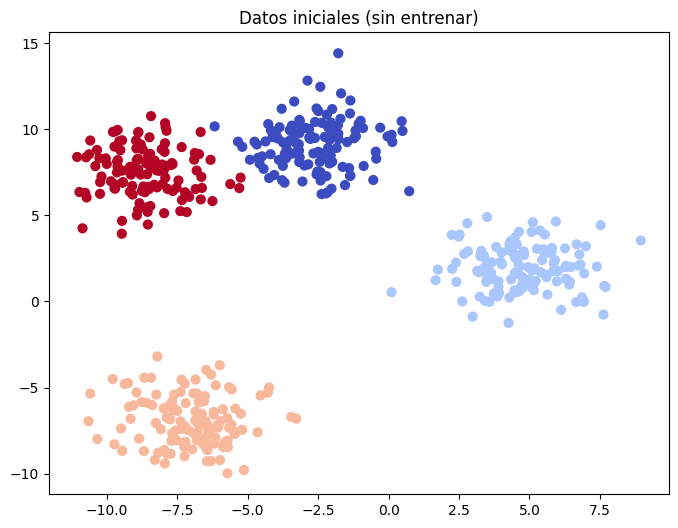

Iniciando entrenamiento del modelo...
Época 50/500, Pérdida: 0.0095
Época 100/500, Pérdida: 0.0064
Época 150/500, Pérdida: 0.0049
Época 200/500, Pérdida: 0.0048
Época 250/500, Pérdida: 0.0037
Época 300/500, Pérdida: 0.0038
Época 350/500, Pérdida: 0.0033
Época 400/500, Pérdida: 0.0029
Época 450/500, Pérdida: 0.0027
Época 500/500, Pérdida: 0.0028


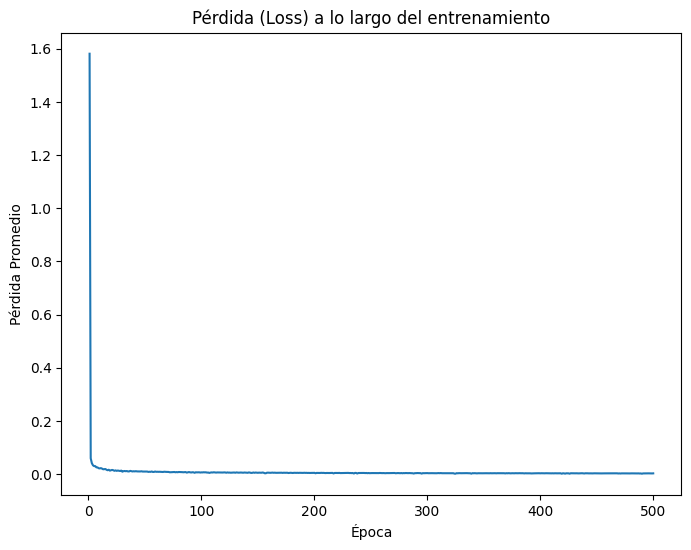


Entrenamiento finalizado. Visualizando fronteras de decisión...


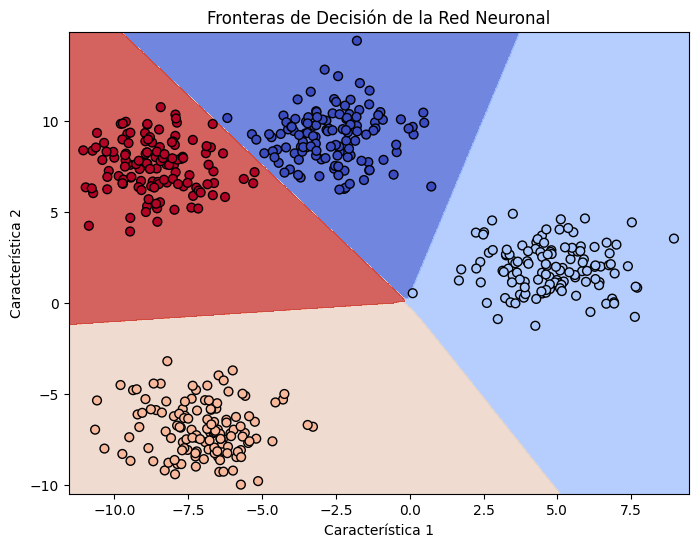

In [20]:
# --- Generar y Visualizar los Datos ---
# Se define la dispersión de los clústeres (cluster_std) para controlar la dificultad del problema
X, y_raw = make_blobs(n_samples=500, centers=4, n_features=2, random_state=42, cluster_std=1.4)
y_one_hot = np.zeros((y_raw.size, y_raw.max() + 1))
y_one_hot[np.arange(y_raw.size), y_raw] = 1

plt.figure(figsize=(8, 6))
plt.title("Datos iniciales (sin entrenar)")
plt.scatter(X[:, 0], X[:, 1], c=y_raw, cmap=plt.cm.coolwarm, s=40)
plt.show()

# --- Entrenar el Modelo ---
# Definir la arquitectura de la red: 2 (entrada) -> 16 (oculta) -> 16 (oculta) -> 4 (salida)
layers_dims = [2, 16, 16, 4]
nn = NeuralNetwork(layers_dims, activation_fn=relu)

print("Iniciando entrenamiento del modelo...")
nn.fit(X, y_one_hot, epochs=500, batch_size=32, learning_rate=0.01)

# --- Visualizar el Gráfico de Pérdida ---
# La curva de pérdida debe descender, indicando que el modelo está aprendiendo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 501), nn.loss_history)
plt.title("Pérdida (Loss) a lo largo del entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida Promedio")
plt.show()

# --- Visualizar el Resultado del Aprendizaje ---
print("\nEntrenamiento finalizado. Visualizando fronteras de decisión...")
# Crear una malla de puntos para predecir sobre todo el espacio 2D
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z_input = np.c_[xx.ravel(), yy.ravel()]
activations_Z, _ = nn.forward_pass_batch(Z_input)
Z = np.argmax(activations_Z[f'a{nn.num_layers-1}'], axis=1).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y_raw, cmap=plt.cm.coolwarm, s=40, edgecolors='k')
plt.title("Fronteras de Decisión de la Red Neuronal")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.savefig('fronteras_decision.png', dpi=300)
plt.show()

## 3. Conclusión del Experimento

El modelo de red neuronal se entrenó con éxito en el conjunto de datos bidimensional. La curva de pérdida descendió de manera pronunciada en las primeras épocas, lo que indica un aprendizaje rápido, y se aplanó a medida que el modelo se aproximaba a una solución óptima. Las fronteras de decisión resultantes son limpias y separan correctamente las cuatro clases de datos, demostrando la capacidad del algoritmo de Backpropagation para resolver problemas de clasificación no lineales.